In [12]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import experimental_model

In [13]:
%matplotlib widget

## Generate synthetic data to play with

In [14]:
### setup the physics and sample a resonance ladder

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1; 

energy_range = [200,225]
spin_groups = [ (3.0,1,0)]  # ,  (4.0,1,0)]

res_par_avg_1 = make_res_par_avg(J_ID=1,          # Change to make spin group!
                                 D_avg = 4.99, 
                                 Gn_avg= 35.5,
                                 n_dof = 1, 
                                 Gg_avg = 64.0, 
                                 g_dof = 1000, 
                                 print = False)
average_parameters = {'3.0':res_par_avg_1}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_range, spin_groups, average_parameters)
resonance_ladder = pd.read_csv("/Users/noahwalton/Documents/GitHub/ATARI/examples/saved_ladder.csv")
resonance_ladder

,Unnamed: 0,E,Gg,Gn1,J,chs,lwave,J_ID
0,0,207.868812,61.274162,0.729421,3.0,1.0,0.0,1.0
1,1,214.086988,66.311363,23.051194,3.0,1.0,0.0,1.0
2,2,217.309029,63.843937,95.131854,3.0,1.0,0.0,1.0
3,3,220.068142,67.201030,23.775496,3.0,1.0,0.0,1.0


In [15]:
### setup experimental transmission model
exp_model_T = experimental_model("T12mm", "transmission", energy_range,
                               
                                    parameters={
                                        'FP':(100.14,0.01)
                                        } ,

                                    channel_width_info={
                                          "chw": [100.0],
                                          "dchw": [0.8]
                                          }
                                                                  )

In [16]:
# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True,
                              "sammy_runDIR": "sammy_runDIR_1"
                              })

model = sammy_classes.theory("Ta181", 180.948030, ac=8.1271, formalism="XCT")

template_creator.make_input_template('template_T.inp', model, exp_model_T, rto)

templates = os.path.realpath('template_T.inp')

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    resonance_ladder,
    os.path.realpath('template_T.inp'), 
    model,
    exp_model_T,
    energy_grid = exp_model_T.energy_grid
)


In [17]:
### Generate syndat
sammyOUT = sammy_functions.run_sammy(sammyINP, rto)
sammyOUT.pw = sammyOUT.pw.loc[:,["E","theo_trans"]]
sammyOUT.pw.rename(columns={"theo_trans":"true"}, inplace=True)

from ATARI.syndat.transmission_rpi import syndat_T
from ATARI.syndat.yield_rpi import syndat_Y

synT = syndat_T(options={'Sample TURP'          : False,
                        'Sample TNCS'           : True, 
                        'Smooth TNCS'           : False,},
                reduction_parameters={"trigo": (10000000, 0),
                                      "trigs": (100000000, 0)})
synT.run(sammyOUT.pw)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'


In [18]:
# fit minchi2 from true parameters and get ECSCM

rto.bayes=True
rto.get_ECSCM = True
sammyINP.initial_parameter_uncertainty=100

sammyINP.experimental_data = synT.data
sammyINP.resonance_ladder["varyE"] = np.ones(len(resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'


In [19]:
# sammyOUT_old = copy(sammyOUT2)

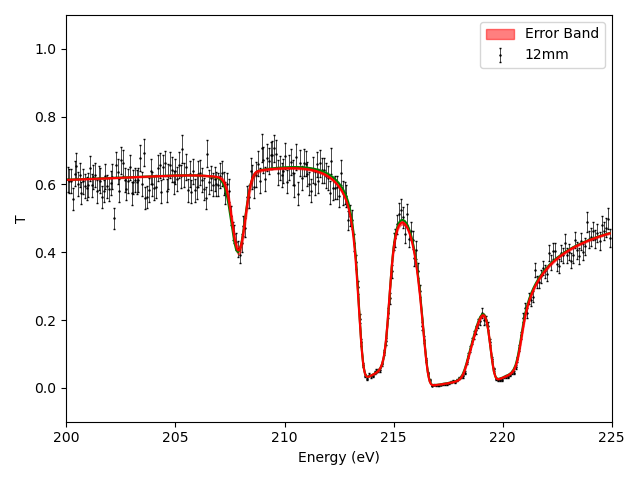

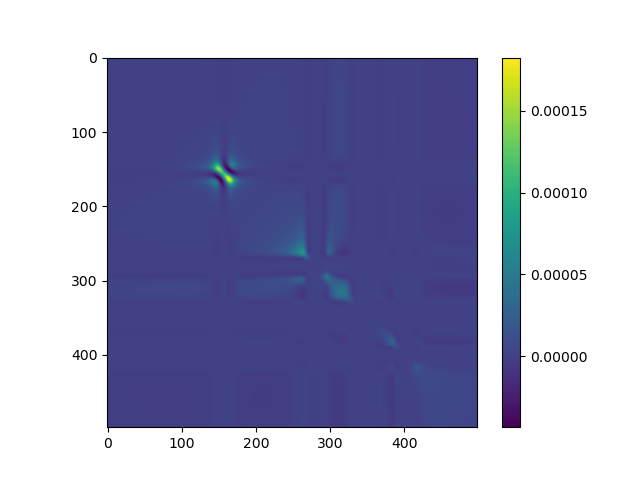

In [20]:

### Plot 
figure()

errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(synT.data.E, synT.data.true, 'g')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans_bayes, 'r')
# plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

xlim([200,225])
ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


figure()
imshow(sammyOUT2.ECSCM)
colorbar()

In [21]:
sammyOUT2.pw

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,200.061290,7.244254,0.875143,7.255060,7.268494,0.614715,0.036135,0.614287,0.613733
1,200.139483,7.353785,0.862453,7.250766,7.264287,0.610209,0.035350,0.614464,0.613906
2,200.217722,7.369261,0.883792,7.246438,7.260046,0.609575,0.036187,0.614643,0.614081
3,200.296006,8.726916,0.871753,7.242072,7.255769,0.556445,0.032583,0.614823,0.614258
4,200.374337,6.832777,0.862382,7.237672,7.251458,0.631942,0.036606,0.615005,0.614435
...,...,...,...,...,...,...,...,...,...
287,224.534560,10.930761,0.854172,11.900294,11.926801,0.479880,0.027533,0.449646,0.448846
288,224.627532,11.463678,0.859643,11.838272,11.863686,0.463006,0.026735,0.451523,0.450753
289,224.720562,11.155949,0.878309,11.778395,11.802772,0.472676,0.027886,0.453342,0.452601
290,224.813650,10.345224,0.931262,11.720549,11.743942,0.499130,0.031222,0.455107,0.454393


In [22]:
samples = 1000
cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

for i in range(samples):
    synT.run(sammyOUT.pw)
    sammyINP.experimental_data = synT.data
    sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
    residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
    cov_true += residual.T@residual
    cov_est += sammyOUT2.ECSCM
    # true.append(cov_true)
    # est.append(cov_est)

SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG\n'
SAMMY gave the following warning or error: b'Note: The following floating-point exceptions

KeyboardInterrupt: 

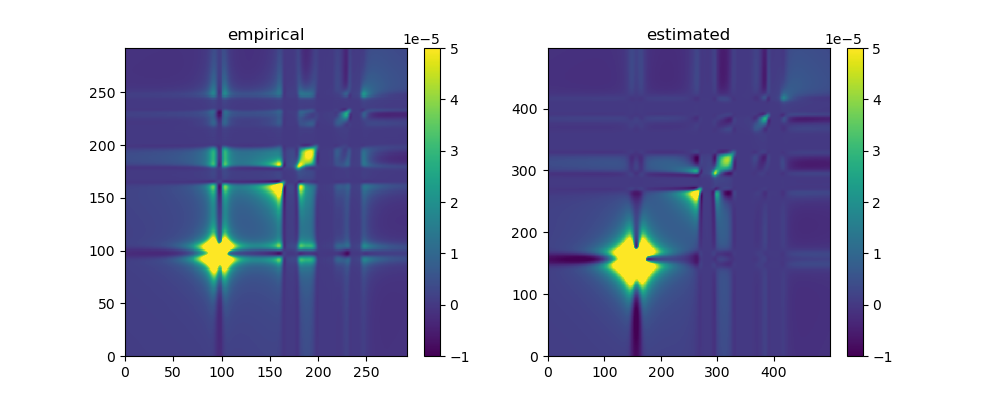

In [ ]:
iest = 0
fig, axes = subplots(1,2, figsize=(10,4))
# im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 5e-5))
im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 5e-5))
axes[0].set_title("empirical")

axes[1].set_title("estimated")
# for ax in axes:
colorbar(im1)

colorbar(im2)

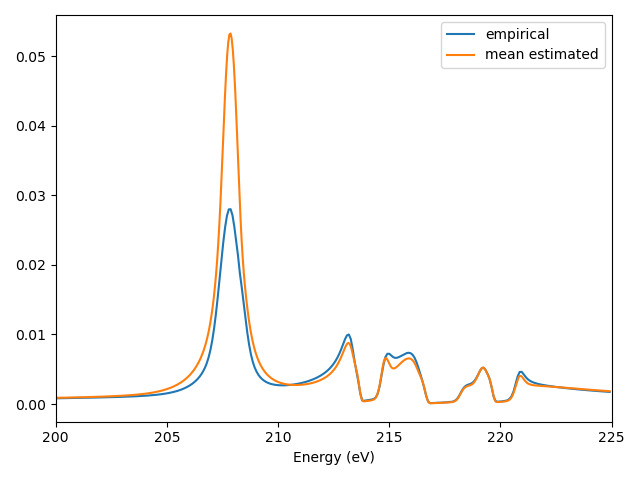

In [ ]:
### Plot 
figure()

# errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
#                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# plot(synT.data.E, synT.data.true, 'g')
plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()